# Inverted logistic regression
Using Bayesian modelling to invert a logistic regression model.

In [1]:
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.linear_model import LogisticRegression

Let's simulate some data: 800 ($N$) observations with 50 ($P$) features (independent variables) and 6 classes ($K$), e.g., categorical emotions. We'll simulate it as a proper multinomial logistic regression model:

\begin{equation}
p(y | X) = \mathrm{softmax}(X\beta + \alpha)
\end{equation}

In [2]:
N = 800
P = 50
K = 6

X = np.random.normal(0, 1, size=(N, P))
α = np.random.normal(0, 0.001, size=K)
β = np.random.normal(0, 0.001, size=(P, K))
mu = X @ β + α
p_y = softmax(mu, axis=1)

# Make discrete labels
y = np.array([np.random.multinomial(1, p_y[i, :]).argmax() for i in range(N)])

Now, suppose we fit a logistic regression model using scikit-learn (note that we *could* also use *pymc3* to fit a Bayesian logistic regression model, but we don't do that here because it's a lot slower).

In [3]:
lr = LogisticRegression()
lr.fit(X, y)
β_hat = lr.coef_.T
α_hat = lr.intercept_

Okay cool, now suppose we want to know the most probable set of features ($X$) given a particular target class ($y = c$), i.e., $p(X | y = c)$. Given that we already know the generative model ($p(y | X)$), we can invert this model by putting a prior on the features ($p(X)$):

\begin{equation}
p(X | y = c) \propto p(y = c | X)p(X)
\end{equation}

In `pymc3`:

In [4]:
with pm.Model() as inverted_lr:
    # Important: we set the SD of the normal prior to 10 times the empirical SD 
    X_ = pm.Normal('X_', mu=0, sd=10*X.std(axis=0), shape=(K, P))
    
    # Use the previously estimated parameters from the LR model!
    mu_ = tt.dot(X_, β_hat) + α_hat
    p_ = tt.nnet.softmax(mu_)
    
    # Do this separately for all classes [0, 1, 2, 3, 4, 5]
    y_ = pm.Categorical('y_', p=p_, observed=range(K))
    trace = pm.sample()

/Users/lukas/software/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [X_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


Now we have a posterior distribution of all $P$ features for all $K$ classes. Let's plot the posterior from the first feature for all 6 classes (including the MAP estimate):

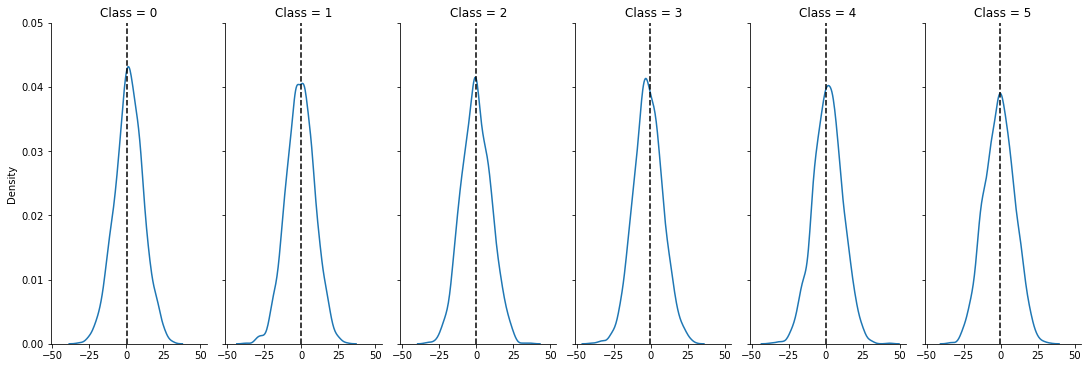

In [5]:
X_map = pm.find_MAP(model=inverted_lr)['X_']
fig, axs = plt.subplots(ncols=K, constrained_layout=True, figsize=(15, 5), sharex=True, sharey=True)
for i, ax in enumerate(axs):
    sns.kdeplot(trace['X_'][:, i, 0], ax=ax)
    ax.axvline(X_map[i, 0], ls='--', c='k')
    ax.set_title(f"Class = {i}")
ax.set_ylim(0, 0.05)
sns.despine()

Just as a check, let's check whether indeed the MAP estimate would reliably lead to the expected class ($p(y | X^{*}$), i.e., a sort of confusion matrix:

<ipython-input-6-977cec036b43>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


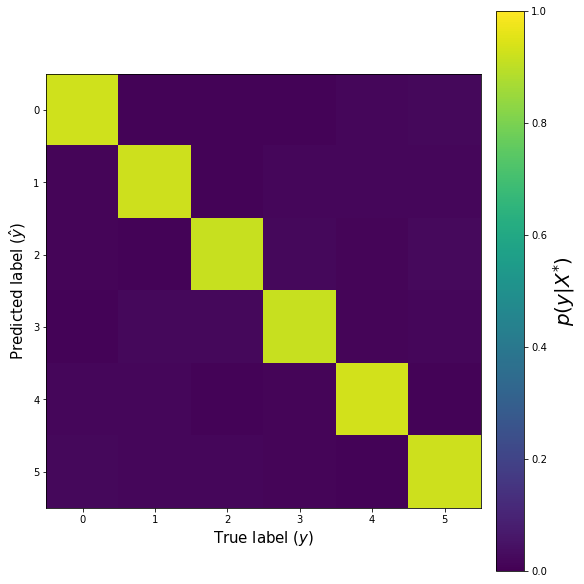

In [6]:
y_opt = softmax(X_map @ β_hat + α_hat, axis=1)
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
mapp = ax.imshow(y_opt, vmin=0, vmax=1)
cbar = plt.colorbar(mapp)
cbar.ax.set_ylabel(r"$p(y | X^{*}$)", fontsize=20)
ax.set_xlabel('True label ($y$)', fontsize=15)
ax.set_ylabel('Predicted label ($\hat{y}$)', fontsize=15)
fig.show()